# Вирішення задачі логістичної регресії за допомогою нейронних мереж

В цій лабораторній роботі Ви створите класифікатор на основі логістичної регресії для розпізнавання котів за допомогою нейронної мережі. 

**Основні вимоги до виконання:**
- не використовуйте в своєму коді циклів (for/while), якщо тільки інструкція прямо не вимагає цього.

**Протягом виконання цієї лабораторної роботи Ви навчитесь:**
- Будувати базову архітектуру алгоритму навчання, включаючи:
    - виконання ініціалізації параметрів мережі
    - розрахування функції витрат та її градієнтів
    - використання алгоритму оптимізації (градієнтний спуск) 
- Зібравши всі необхідні модулі Ви отримаєте вірне рішення задачі класифікації котів.

## 1 - Необхідні пакети ##

Для початку необхідно завантажити необхідні для виконання цієї лабораторної роботи пакети. 
- [numpy](www.numpy.org).
- [h5py](http://www.h5py.org) це загальний пакет для взаємодії з набором даних, який зберігається у файлі H5.
- [matplotlib](http://matplotlib.org) бібліотека для побудови графіків.
- [PIL](http://www.pythonware.com/products/pil/) та [scipy](https://www.scipy.org/) пакети для тестування Вашої моделі із власною картинкою у фінальній частині лабораторної роботи.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image


%matplotlib inline

## 2 - Постановка завдання ##

**Вихідні умови до завдання**: Вам надано набір даних, що містить:  
    - навчальний набір даних містить  m_train зображень позначених як `кіт (cat)` (y=1) або `НЕ кіт (non-cat)` (y=0)  
    - тестовий набір даних містить m_test зображень позначених як `кіт (cat)` (y=1) або `НЕ кіт (non-cat)` (y=0)  
    - розмірність кожного зображення (num_px, num_px, 3), де 3 - для 3 каналів (RGB). Таким чином, кожне зображення є квадратним (висота = num_px) та (ширина = num_px).

Вам необхідно побудувати простий алгоритм розпізнавання-зображень, який вірно класифікує чи зображено на картинці кота чи НЕ кота.

Давайте більш детально познайомимося з набором даних. Завантажте дані, запустивши наступний код.

In [33]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  

    classes = np.array(test_dataset["list_classes"][:])  

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [59]:

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()


Постфікс "_orig" в кінці наборів  зображень (навчальному наборі та тестовому), є позначкою того, що ці зображення будуть попередньо опрацьовуватись. Після попередньої обробки Ви отримаєте train_set_x та test_set_x (мітки train_set_y та test_set_y не потребують попередньої обробки).

Кожен рядок вашого train_set_x_orig та test_set_x_orig - це масив, що представляє зображення. Ви можете візуалізувати приклад, запустивши наступний код. для того, щоб побачити інші зображення змініть знначення `index` та повторно запустіть код. 

In [35]:
import matplotlib.pyplot as plt

def display_example(train_set_x_orig, train_set_y, classes, index):
    """
    Display an example picture from the dataset.
    
    Arguments:
    train_set_x_orig -- numpy array containing training set features
    train_set_y -- numpy array containing training set labels
    classes -- list of classes
    index -- index of the example picture to display
    """
    plt.imshow(train_set_x_orig[index])  
    plt.show()
    
    
    label = train_set_y[:, index]
    class_name = classes[np.squeeze(label)].decode("utf-8")
    print("y = " + str(label) + ", it's a '" + class_name + "' picture.")


Багато помилок при навчанні нейронних мереж виникає в ситуаціях, коли не співпадають розмірності матриць та векторів. 

**Завдання 1:** Знайти значення для:
    - m_train (кількість навчальних прикладів)
    - m_test (кількість тетових прикладів)
    - num_px (= height = width (вистоа та ширина) зображень в навчальному наборі)  

**NB!!!** `train_set_x_orig` це numpy-array розмірністю (m_train, num_px, num_px, 3). Для перевірки розмірності `m_train`треба прописати `train_set_x_orig.shape[0]`.

In [36]:

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


print("Number of training examples: m_train =", m_train)
print("Number of testing examples: m_test =", m_test)
print("Height/Width of each image: num_px =", num_px)
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape:", train_set_x_orig.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x shape:", test_set_x_orig.shape)
print("test_set_y shape:", test_set_y.shape)


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Виконавши вірно завдання 1, Ви повинні отримати наступні значення m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
</table>


Для зручності необхідно трасформувати зображення (num_px, num_px, 3) в numpy-array розмірності (num_px $*$ num_px $*$ 3, 1). Після цього навчальний та тестовий набори даних перетворяться в numpy-array, де кожен стовпець представляє зображення. Мають бути стовпці m_train та, відповідно, m_test.

**Завдання 2:** Необхідно переформатувати навчальні та тестові набори даних так, щоб зображення розміру (num_px, num_px, 3) були представлені в вектори-стовпці розмірності (num\_px $ * $ num\_px $ * $ 3, 1).

Для того щоб розпрямити матрицю  X розмірності (a, b, c, d) до матриці X_flatten розмірності (b $ * $ c $ * $ d, a), необхідно використати: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [60]:

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))
print("sanity check after reshaping: " + str(train_set_x_flatten[0:5, 0]))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Виконавши вірно це завдання ви отримуєте**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Для представлення кольорових зображень для кожного пікселя повинні бути вказані червоний, зелений та синій канали (RGB), тому значення пікселя насправді є вектором із трьох чисел в діапазоні від 0 до 255.

Ви вже знаєте, що одним з основних етапів попередньої обробки даних в машинному навчанні є центрування та стандартизація набору даних. Для виконання цього єтапу необхідно відняти середнє значення всього numpy-масиву з кожного прикладу, а потім поділити кожен приклад на стандартне відхилення всього numpy-масиву.  
**NB!!** Для зображень це простіше і зручніше, і майже так само добре працює просто розділити кожен рядок набору даних на 255 (максимальне значення піксельного каналу).

Давайте стандартизуємо наші дані виконавши наступний код!

In [38]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

**NB!!!:**

Основні етапи попередньої обробки даних:
- Необхідно визначити розміри та розмірність даних (m_train, m_test, num_px, ...)
- Необхідно форматувати зображеня таким чином, щоб кожен приклад тепер був вектором розміру  (num_px \* num_px \* 3, 1)
- Необхідно стандартизувати дані 

## 3 - Загальна архітектура алгоритму навчання ##

Тепер давайте розробимо простий алгоритм, для того, щоб розрізняти зображеня котів від зображень, що не належать до котів.

Вам необхідно побудувати логістичну регресію використовуючи нейронну мережу.

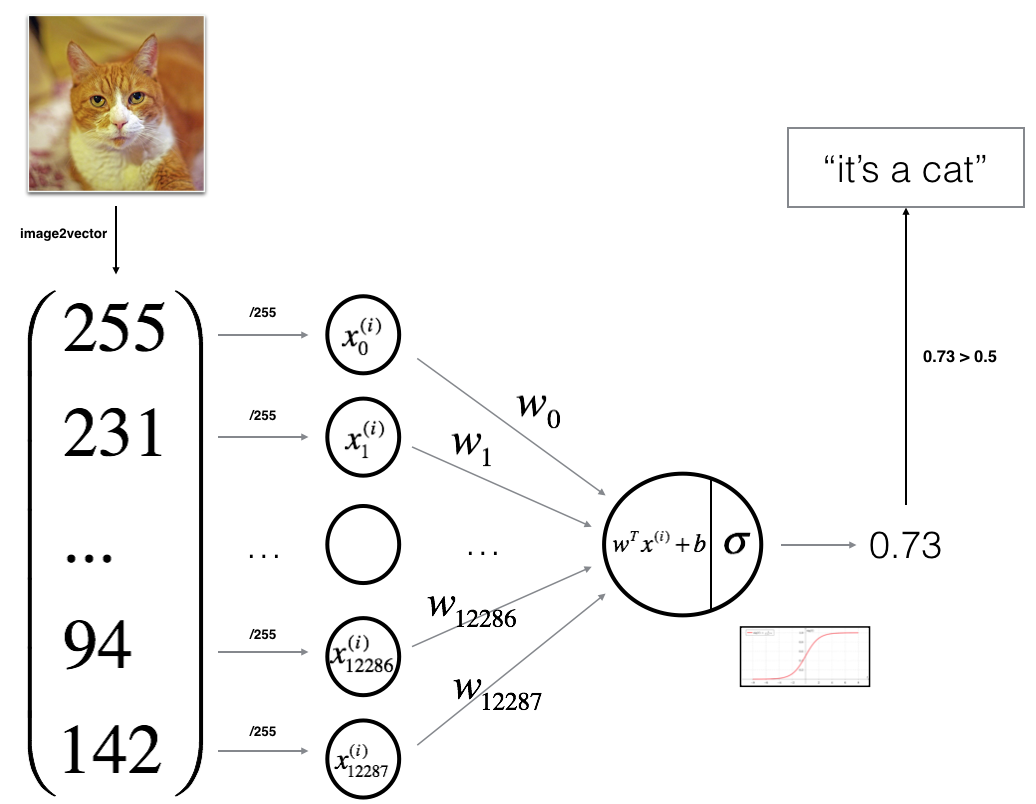

**Математичне обгрунтування алгоритну**:

Для одного прикладу $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Після цього треба розрахувати функцію витрат визначивши сумму всіх елементів:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Основні етапи**:
В цьому завданні необхідно виконати наступні кроки: 
    - Ініціалізувати параметри моделі
    - Навчити параметри моделі мінімізувавши функцію витрат 
    - Використати навчені параметри для побудови прогнозів (на тестовому наборі даних)
    - Провести аналіз отриманих результатів та зробити висновки по побудованій моделі

## 4 - В цій частині необхідно зібрати всі основні модулі нашої моделі ## 

основні етапи побудови моделі нейронної мережі:
1. Визначити структуру моделі (наприклад кількість вхідних фічей) 
2. Ініціалізувати параметри моделі
3. Створити цикл:
    - Розрахувати current loss (forward propagation)
    - Розрахувати current gradient (backward propagation)
    - Оновити параметри (gradient descent)

`model()` - це загальний блок, який об'єднює 1-3 окремі функції інтегровані в одну спільну.

### 4.1 - Допоміжні функції

**Завдання 3**: Необхідно реалізувати функцію `sigmoid()`. Як ви бачили на малюнку вище, вам потрібно обчислити $ sigmoid (w ^ T x + b) = \frac {1} {1 + e ^ {- (w ^ T x + b)}} $, щоб зробити прогнози. Використовуйте `np.exp()`.

In [39]:
import numpy as np

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s


In [40]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Виконавши вірно це завдання ви отримуєте**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Ініціалізація параметрів

**Завдання 4:** Необхідно реалізувати ініціалізацію параметрів. Вам потрібно ініціалізувати `w` як вектор нулів. Якщо ви не знаєте, яку функцію numpy використовувати, знайдіть `np.zeros()` у документації бібліотеки Numpy.

In [41]:
import numpy as np

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0
   
    assert w.shape == (dim, 1)
    assert isinstance(b, float) or isinstance(b, int)
    
    return w, b



In [42]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Виконавши вірно це завдання ви отримуєте**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Для вихідних зображень вагові коефіцієнти `w` мають розмірність (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Пряме та зворотнє поширення 

Тепер, коли  параметри ініціалізовані, можна навчати параметри на основі прямого та зворотного поширення помилки.

**Завдання 5:** Написати функцію `propagate()`, яка обчислює функцію втрат та градієнт.

**NB!!!**:

Пряме поширення:
- вихідний вектор  X
- необхідно обчислити $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- розрахувати функцію втрат: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$  

Наступні дві формули Вам необхідно використати: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [43]:
import numpy as np

def initialize_with_zeros(dim):
    """
    This function initializes weights (w) and bias (b) to zeros.
    
    Arguments:
    dim -- size of the weight vector we want
    
    Returns:
    w -- initialized weight vector of shape (dim, 1)
    b -- initialized bias scalar
    """
    
    w = np.zeros((dim, 1))
    b = 0
   
    assert w.shape == (dim, 1)
    assert isinstance(b, float) or isinstance(b, int)
    
    return w, b


In [62]:
import numpy as np

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the cost function with respect to w and b
    cost -- negative log-likelihood cost for logistic regression
    """
    m = X.shape[1]


    A = sigmoid(np.dot(w.T, X) + b)  
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))  

    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)

    assert dw.shape == w.shape
    assert isinstance(db, float)
    cost = np.squeeze(cost)
    assert cost.shape == ()

    grads = {"dw": dw,
             "db": db}

    return grads, cost


w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])


grads, cost = propagate(w, b, X, Y)

# 


**Виконавши вірно це завдання ви отримуєте**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Оптимізація
- Необхідно ініціалізувати параметри.
- Обчислити функцію втрат та її градієнт.
- Після цього можна оптимізувати параметри використовуючи градієнтний спуск.

**Завдання 6:** Необхідно записати функцію оптимізації. Основна мета - навчити $w$ та $b$ мінімізувавши функцію витрат $J$. Для параметру $\theta$, оновлене правило : $ \theta = \theta - \alpha \text{ } d\theta$, де $\alpha$ is параметер кроку навчання (learning rate).

In [63]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        
        grads, cost = propagate(w, b, X, Y)
        
        
        dw = grads["dw"]
        db = grads["db"]
        
       
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        
        if i % 100 == 0:
            costs.append(cost)
        
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [49]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


**Виконавши вірно це завдання ви отримуєте**: 

<table>
    <tr>
       <td>**w**</td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    <tr>
       <td>**b**</td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**Завдання 7:** Попередня функція повертає навчені w та b. Тепер можна використовувати w та b для прогнозування міток класів для набору даних X. Реалізуйте функцію `predict()`. Існує два етапи обчислення прогнозів:

1. Необхідно обчислити $\hat{Y} = A = \sigma(w^T X + b)$

2. Перетворіть записи `a` у 0 (якщо активація <= 0,5) або 1 (якщо активація > 0,5), збережіть прогнози у векторі `Y_prediction`. Тут можете використовувати оператор `if` /` else` у циклі `for` (хоча існує також спосіб векторизації цього). 

In [64]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    assert Y_prediction.shape == (1, m)
    
    return Y_prediction


In [51]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


**Виконавши вірно це завдання ви отримуєте**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


**NB!!!:**
До цього моменту Ви реалізували:
- Провели ініціалізацію (w,b)
- Провели покрокову оптимізацію навчених параметрів (w,b):
    - розрахували функцію втрат та її градієнти
    - оновили параметри використовуючи градієнтний спуск
- На основі навчених (w,b) побудували прогноз міток класів щодо окремого зображення з вибірки

## 5 - Зведення реалізованих функцій в єдину модель##

Тепер об'єднаємо та структуруємо всі наші окреми блоки (функції, реалізовані в попередніх частинах),  в єдину модель в правильному порядку.

**Завдання 8:** Створити функцію загальної моделі, використавши наступні блоки:
    - Y_prediction_test для прогнозів на тестових даних
    - Y_prediction_train для прогнозів на навчальних даних
    - w, costs, grads для результатів оптимізації for the outputs of optimize()

In [66]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    
   
    w, b = initialize_with_zeros(X_train.shape[0])

  
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    
    w = parameters["w"]
    b = parameters["b"]
    
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Запустіть наступний рядок для того, щоб навчити модель.

In [53]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Виконавши вірно це завдання ви отримуєт**: 

<table style="width:40%"> 
    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> ... </center> </td> 
        <td> <center> ... </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**NB!!!**: Точність навчання моделі на тренувальному наборі даних близька до 100%. Це гарний результат, який демострує, що модель яку Ви зібрали навчена вірно. Точність моделі на тестових даних становить 68%. Це насправді непогано для цієї простої моделі, враховуючи невеликий набір даних, який ми використовували, і що логістична регресія є лінійним класифікатором. 

Використовуючи наведений нижче код (і змінюючи змінну `index`), ви можете переглянути прогнози на зображеннях тестової вибірки.

y = 1, you predicted that it is a "cat" picture.


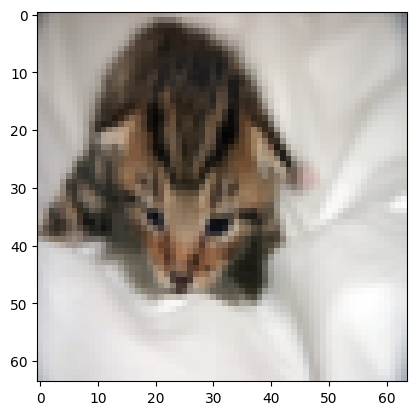

In [54]:

index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0, index])].decode("utf-8") +  "\" picture.")

Тепер побудуємо графік функції витрат та її градієгтів.

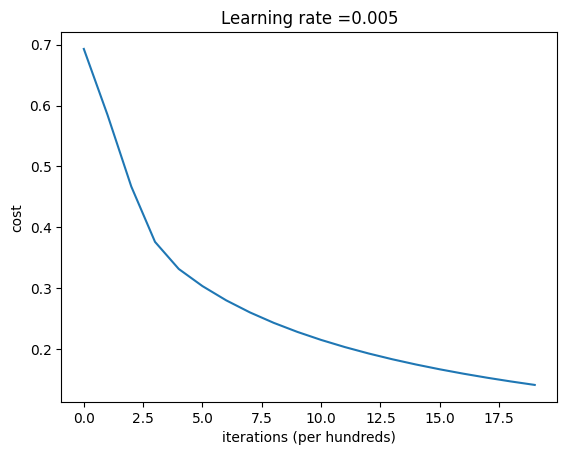

In [67]:

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Інтерпретація**:

1.   
2. 
3. ... 


## 6 - Аналіз результатів ##

Тепер необхідно проаналізувати параметр швидкості навчання.

#### Вибір параметру кроку навчання ####

**NB!!!**:
Для того, щоб метод градієнтного спуску працював, ви повинні розумно підбирати параметр кроку навчання. Параметр кроку навчаннч $ \ alpha $ визначає, наскільки швидко ми оновлюємо параметри. Якщо обрати цей параметер дуже великим, можна "перескочити" оптимальне значення. Так само, якщо він занадто малий, знадобиться занадто багато ітерацій, щоб дійти до оптимума. Тому етап налаштування параметру кроку навчання є дуже важливим.

Давайте порівняємо криву навчання створеної моделі з кількома варіантами параметру кроку навчання. Запустіть наступний код. Спробуйте інші значення `learning_rates`. Проаналізуйте отримані результати. 

Training model with learning rate: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %
-------------------------------------------------------
Training model with learning rate: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %
-------------------------------------------------------
Training model with learning rate: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %
-------------------------------------------------------


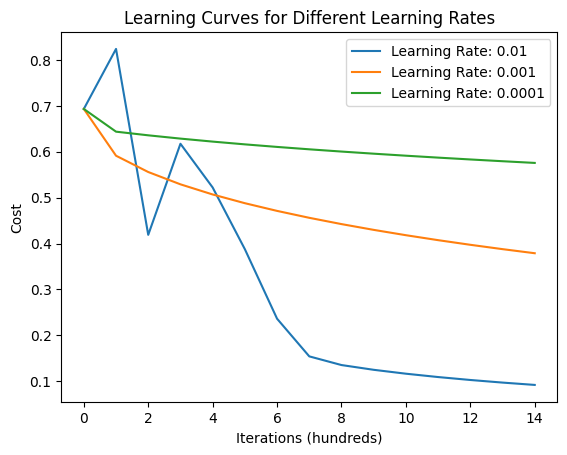

In [68]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}


for rate in learning_rates:
    print("Training model with learning rate:", rate)
    models[str(rate)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=rate, print_cost=False)
    print("-------------------------------------------------------")


for rate in learning_rates:
    plt.plot(np.squeeze(models[str(rate)]["costs"]), label="Learning Rate: " + str(models[str(rate)]["learning_rate"]))

plt.ylabel('Cost')
plt.xlabel('Iterations (hundreds)')
plt.title('Learning Curves for Different Learning Rates')
plt.legend()
plt.show()


**Інтерпретація**: 

1.   
2. 
3. ... 




## 7 - Тестування розробленої моделі на власному зображені ##

Використайте своє власне зображення щоб перевірити працездатсність моделі. Для цього:  
    1. Додайте своє зображення до цього Jupyter Notebook;  
    2. Змініть ім'я файлу в наступному коді;  
    4. Запустіть код на власному зображені та перевірте вірність класифікації (1 = cat, 0 = non-cat)!

In [57]:
from PIL import Image

Training model with learning rate: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %
-------------------------------------------------------
Training model with learning rate: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %
-------------------------------------------------------
Training model with learning rate: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %
-------------------------------------------------------


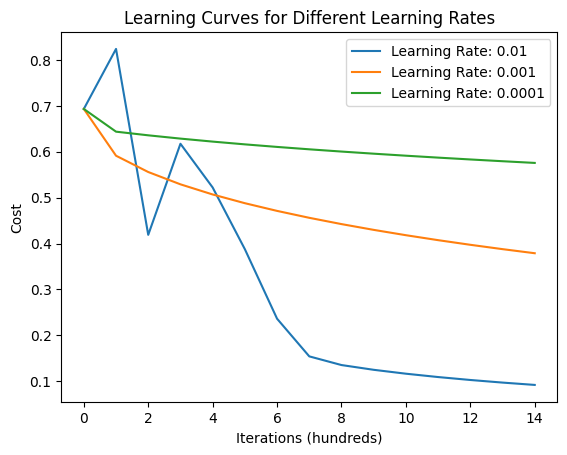

In [69]:

learning_rates = [0.01, 0.001, 0.0001]
models = {}


for rate in learning_rates:
    print("Training model with learning rate:", rate)
    models[str(rate)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=rate, print_cost=False)
    print("-------------------------------------------------------")


for rate in learning_rates:
    plt.plot(np.squeeze(models[str(rate)]["costs"]), label="Learning Rate: " + str(models[str(rate)]["learning_rate"]))


plt.ylabel('Cost')
plt.xlabel('Iterations (hundreds)')
plt.title('Learning Curves for Different Learning Rates')
plt.legend()
plt.show()


Зверніть увагу на ці посилання:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c